In [1]:
%load_ext autoreload
%autoreload 2

In [162]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import ImageLayoutDataset, PatternExploitingDataset, SplitWordsDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

## Importing dataset

In [3]:
dataset = load_dataset("nielsr/funsd")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
!mkdir logs
model_name = "PET"
dataset_name = "FUNSD"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


In [9]:
def pattern1(word : str,
            tokenizer):
    return f" In a document, where is the word {word} most frequently encountered, be it in the header, a question, or an answer? {tokenizer.mask_token}"

In [32]:
def pattern2(word : str,
             tokenizer):
    return f"{word} is an example of {tokenizer.mask_token}"

In [45]:
data = PatternExploitingDataset(
    dataset['train'],
    tokenizer,
    pattern2,
    num_samples = 10
)

In [46]:
' '.join(dataset['train'][0]['words'])

'R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp'

In [47]:
labels_idx_keymap = {
    "nothing": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [48]:
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

In [49]:
device = "cuda"


model.train()

alpha = 0
n_epochs = 10

optmizer = AdamW(model.parameters(), 1e-5)
history = []

for epoch in range(n_epochs):
    y_true_train = torch.tensor([],device=device)
    y_pred_train = torch.tensor([],device=device)

    for i in tqdm(range(len(data))):

        phrases, labels = data[i]

        for idx, phrase in (enumerate(phrases)):
            tokens = tokenizer(
                phrases,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=32
            )

            correct_word = tokenizer.tokenize(labels[idx])[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids != tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
                labels = y
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["nothing"]].item()

            logits_list = torch.tensor([
                none_logits,
                question_logits, 
                answer_logits,
                header_logits
            ])

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            predicted_value = logits_list.argmax().item()

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

            logging.info(f"real value: {real_value}, predicted value : {predicted_value}")

            real_list = [0,0,0,0]
            real_list[real_value] =1

            real_list = torch.tensor(
                real_list
            )

            ce_loss = cross_entropy(
                logits_list.softmax(dim = 0).to(torch.float64),
                real_list.to(torch.float64)
            )

            mlm_loss = outputs.loss
            loss = (1-alpha)*ce_loss + mlm_loss*alpha

            loss.backward()

            optmizer.step()
            optmizer.zero_grad()

    f1 = multiclass_f1_score(
        y_pred_train,
        y_true_train,
        num_classes=4
    )
    history.append(f1)

    logging.info(f'''
                 
    -------------------------
        End of epoch {epoch} 
        F1 score : {f1}     
    ''')

    logging.info(f'''
        {multiclass_confusion_matrix(
        y_pred_train.to(torch.int64),
        y_true_train.to(torch.int64),
        num_classes=4
        )}
    ''')

 20%|██        | 2/10 [01:13<04:52, 36.52s/it]


KeyboardInterrupt: 

In [21]:
logits_list.softmax(dim= 0)

tensor([0.2007, 0.5785, 0.0553, 0.1655])

In [22]:
real_list

tensor([1, 0, 0, 0])

In [18]:
ce_loss = cross_entropy(
    logits_list.to(torch.float64),
    predicted_list.to(torch.float64)
)


NameError: name 'predicted_list' is not defined

In [70]:
ce_loss

tensor(1.5447, dtype=torch.float64)

In [71]:
loss = (1-alpha) * ce_loss + alpha*mlm_loss

In [72]:
labels_idx_keymap = {
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [87]:
validation_dataset = PatternExploitingDataset(
    dataset['test'],
    tokenizer,
    pattern1,
    num_samples=30
)

In [88]:
y_true_train = torch.tensor([],device=device)
y_pred_train = torch.tensor([],device=device)

with torch.no_grad():
    for i in tqdm(range(len(validation_dataset))):

        phrases, labels = validation_dataset[i]

        for idx, phrase in (enumerate(phrases)):
            tokens = tokenizer(
                phrases,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=32
            )

            correct_word = tokenizer.tokenize(labels[idx])[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids!= tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()

            logits = {
                "question": question_logits,
                "answer": answer_logits,
                "header": header_logits,
                "none": none_logits
            }

            predicted_value = sorted(
                logits.items(), 
                reverse= True, 
                key = lambda x: x[1]
            )[0][0]

            predicted_value = labels_idx_keymap[predicted_value]

            logging.info(predicted_value)

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [06:50<00:00, 13.69s/it]


In [62]:
correct_word

'none'

In [75]:
logits

{'question': 3.0634965896606445,
 'answer': 2.415207624435425,
 'header': 2.9105570316314697,
 'none': 1.0707943439483643}

In [89]:
predicted_value

1

In [90]:
multiclass_f1_score(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

tensor(0.2324, device='cuda:0')

In [96]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

In [107]:
confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())

{'none': 0, 'question': 1, 'answer': 2, 'header': 3}

In [110]:
{v:k for k, v in labels_idx_keymap.items()}

{0: 'none', 1: 'question', 2: 'answer', 3: 'header'}

In [115]:
confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

Text(0.5, 1.0, '\n    Confusion matrix\n    Pattern Exploited Training    \n')

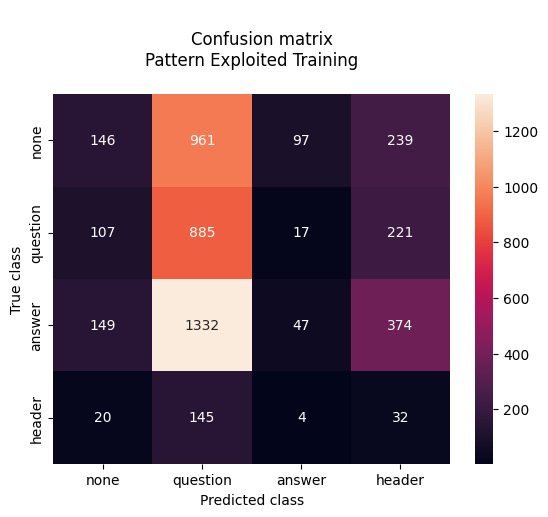

In [125]:
sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title('''
    Confusion matrix
    Pattern Exploited Training    
''')

## Adding sequence

In [152]:
def pattern3(
    phrase : str,
    word: str,
    tokenizer
):
    return f"In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? {tokenizer.mask_token}"

### Tokenization

In [174]:
splitted_dataset = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern3,
)

100%|██████████| 149/149 [00:00<00:00, 1177.62it/s]


In [170]:
len(splitted_dataset)

149

In [169]:
splitted_dataset[0]

[{'pattern': "In the phrase 'R&D . Suggestion. Date', the R&D is in the header, in a question, or in an answer? [MASK]",
  'label': 'NOTHING'},
 {'pattern': "In the phrase 'R&D . Suggestion. Date', the Suggestion. is in the header, in a question, or in an answer? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase 'R&D . Suggestion. Date', the Date is in the header, in a question, or in an answer? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. . M', the Licensee is in the header, in a question, or in an answer? [MASK]",
  'label': 'ANSWER'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. . M', the Yes is in the header, in a question, or in an answer? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name /

In [204]:
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

In [202]:
labels_idx_keymap = {
    "nothing": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [207]:
device = "cuda"


model.train()

alpha = 1e-4
n_epochs = 10

optmizer = AdamW(model.parameters(), 1e-5)
history = []

n_shots = 10

for epoch in range(n_epochs):
    y_true_train = torch.tensor([],device=device)
    y_pred_train = torch.tensor([],device=device)

    for i in tqdm(range(n_shots)):

        for processed_data in (splitted_dataset[i]):
            phrase = processed_data['pattern']
            label = processed_data["label"]

            tokens = tokenizer(
                phrase,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=256
            )

            correct_word = tokenizer.tokenize(label)[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids != tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
                labels = y
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["nothing"]].item()

            logits_list = torch.tensor([
                none_logits,
                question_logits, 
                answer_logits,
                header_logits
            ])

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            predicted_value = logits_list.argmax().item()

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

            # logging.info(f"real value: {real_value}, predicted value : {predicted_value}")

            real_list = [0,0,0,0]
            real_list[real_value] =1

            real_list = torch.tensor(
                real_list
            )

            ce_loss = cross_entropy(
                logits_list.softmax(dim = 0).to(torch.float64),
                real_list.to(torch.float64)
            )

            mlm_loss = outputs.loss
            loss = (1-alpha)*ce_loss + mlm_loss*alpha

            loss.backward()

            optmizer.step()
            optmizer.zero_grad()

    f1 = multiclass_f1_score(
        y_pred_train,
        y_true_train,
        num_classes=4
    )
    history.append(f1)

    logging.info(f'''
                 
    -------------------------
        End of epoch {epoch} 
        F1 score : {f1}     
    ''')

    logging.info(f'''
        {multiclass_confusion_matrix(
        y_pred_train.to(torch.int64),
        y_true_train.to(torch.int64),
        num_classes=4
        )}
    ''')
    break
    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:29<00:00,  8.92s/it]


Text(0.5, 1.0, '\n    Confusion matrix - Train \n    Pattern Exploited Training  \n    alpha = 0.0001  \n')

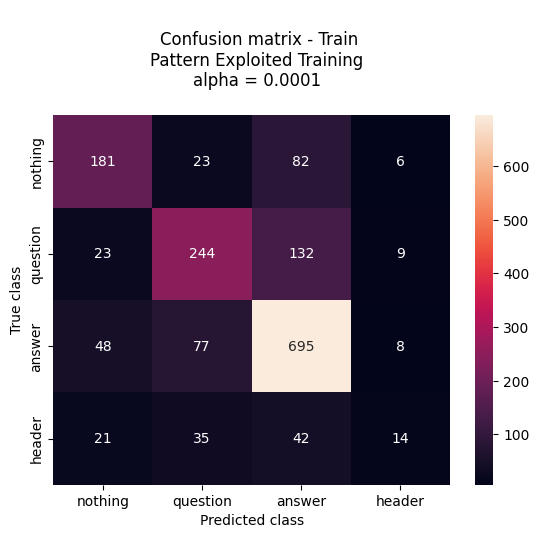

In [218]:
period = "Train"
conf_matrix = multiclass_confusion_matrix(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period} 
    Pattern Exploited Training  
    alpha = {alpha}  
''')

In [209]:
multiclass_f1_score(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

tensor(0.6915, device='cuda:0')

### Validation results

In [212]:
validation_dataset = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern3,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 986.73it/s]


In [213]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)

num_shots_validation = 30

with torch.no_grad():
    for i in tqdm(range(num_shots_validation)):

        for processed_data in (splitted_dataset[i]):

            phrase = processed_data['pattern']
            label = processed_data["label"]

            tokens = tokenizer(
                phrase,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=256
            )

            correct_word = tokenizer.tokenize(label)[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids!= tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()

            logits = {
                "question": question_logits,
                "answer": answer_logits,
                "header": header_logits,
                "none": none_logits
            }

            predicted_value = sorted(
                logits.items(), 
                reverse= True, 
                key = lambda x: x[1]
            )[0][0]

            predicted_value = labels_idx_keymap[predicted_value]

            # logging.info(predicted_value)

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_val = torch.cat([
                y_true_val,
                torch.tensor([real_value]).to(device)
            ])

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:49<00:00,  5.65s/it]


Text(0.5, 1.0, '\n    Confusion matrix - Test\n    Pattern Exploited Training    \n')

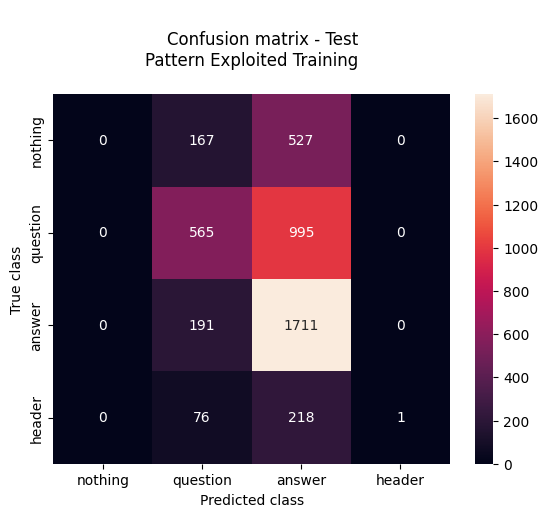

In [216]:
period = "Test"
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period}
    Pattern Exploited Training    
    alpha = {alpha}
''')

In [215]:
multiclass_f1_score(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

tensor(0.5116, device='cuda:0')